In [1]:
%matplotlib inline
!nvidia-smi

Mon Nov 13 23:17:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/VikashKumarShaw1994/DNN_invariant_time-rescaling.git DNN_invariant_sithcon

In [3]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from DNN_invariant_sithcon.SITHCon.sithcon import SITHCon_Layer
#from sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random

<class 'torch.cuda.FloatTensor'>


In [4]:
Braille_CODE_DICT = {
",": "01000000",
".": "01001100",
"(": "01001000",
"-": "01100000",
"/": "00100000",
"?": "01100100",
")": "01101000",
"A": "10000010",
"B": "11000010",
"C": "10010010",
"D": "10011010",
"E": "10001010",
"F": "11010010",
"G": "11011010",
"H": "11001010",
"I": "01010010",
"J": "01011010",
"K": "10100010",
"L": "11100010",
"M": "10110010",
"N": "10111010",
"O": "10101010",
"P": "11110010",
"Q": "11111010",
"R": "11101010",
"S": "01110010",
"T": "01111010",
"U": "10100110",
"V": "11100110",
"W": "01011110",
"X": "10110110",
"Y": "10111110",
"Z": "10101110",
"1": "10000001",
"2": "11000001",
"3": "10010001",
"4": "10011001",
"5": "10001001",
"6": "11010001",
"7": "11011001",
"8": "11001001",
"9": "01010001",
"0": "01011001",
 }

In [5]:
43/15

2.8666666666666667

In [7]:

Braille_code_numpy = {key:np.array([0]+[int(x) for x in Braille_CODE_DICT[key]] + [0, 0])
                    for key in Braille_CODE_DICT.keys()}

subset = list(Braille_code_numpy.keys())


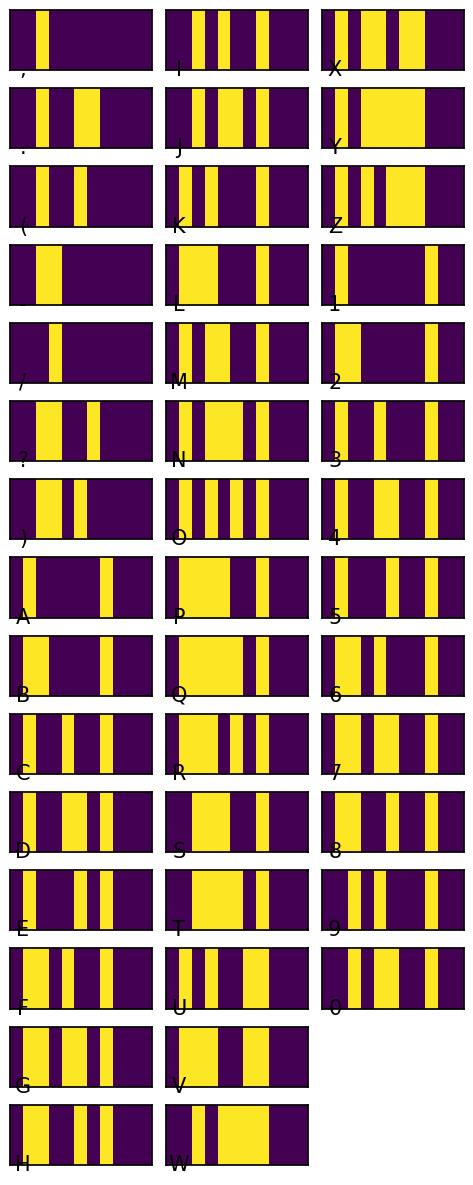

In [8]:
window_size = 20
lw=5
ms = 15
with sn.plotting_context("notebook", font_scale=4):
    fig = plt.figure(figsize=(30,15), )
    spec = gridspec.GridSpec(nrows=15, ncols=15, hspace=.3, wspace=.1,
                             figure=fig)


    for x, k in enumerate(Braille_code_numpy.keys()):
        ax = fig.add_subplot(spec[x%15, int(x/15)])
        ax.text(0.5, 0.5, str(k), fontsize=15, ha='center', va='center', color='black')

        ax.imshow(Braille_code_numpy[k][np.newaxis], aspect='auto')
        ax.set_xticks([])
        ax.set_yticks([])


       perf  scale
0  0.465116      1
1  0.883721      2
2  1.000000      5
3  1.000000      6
4  1.000000      7


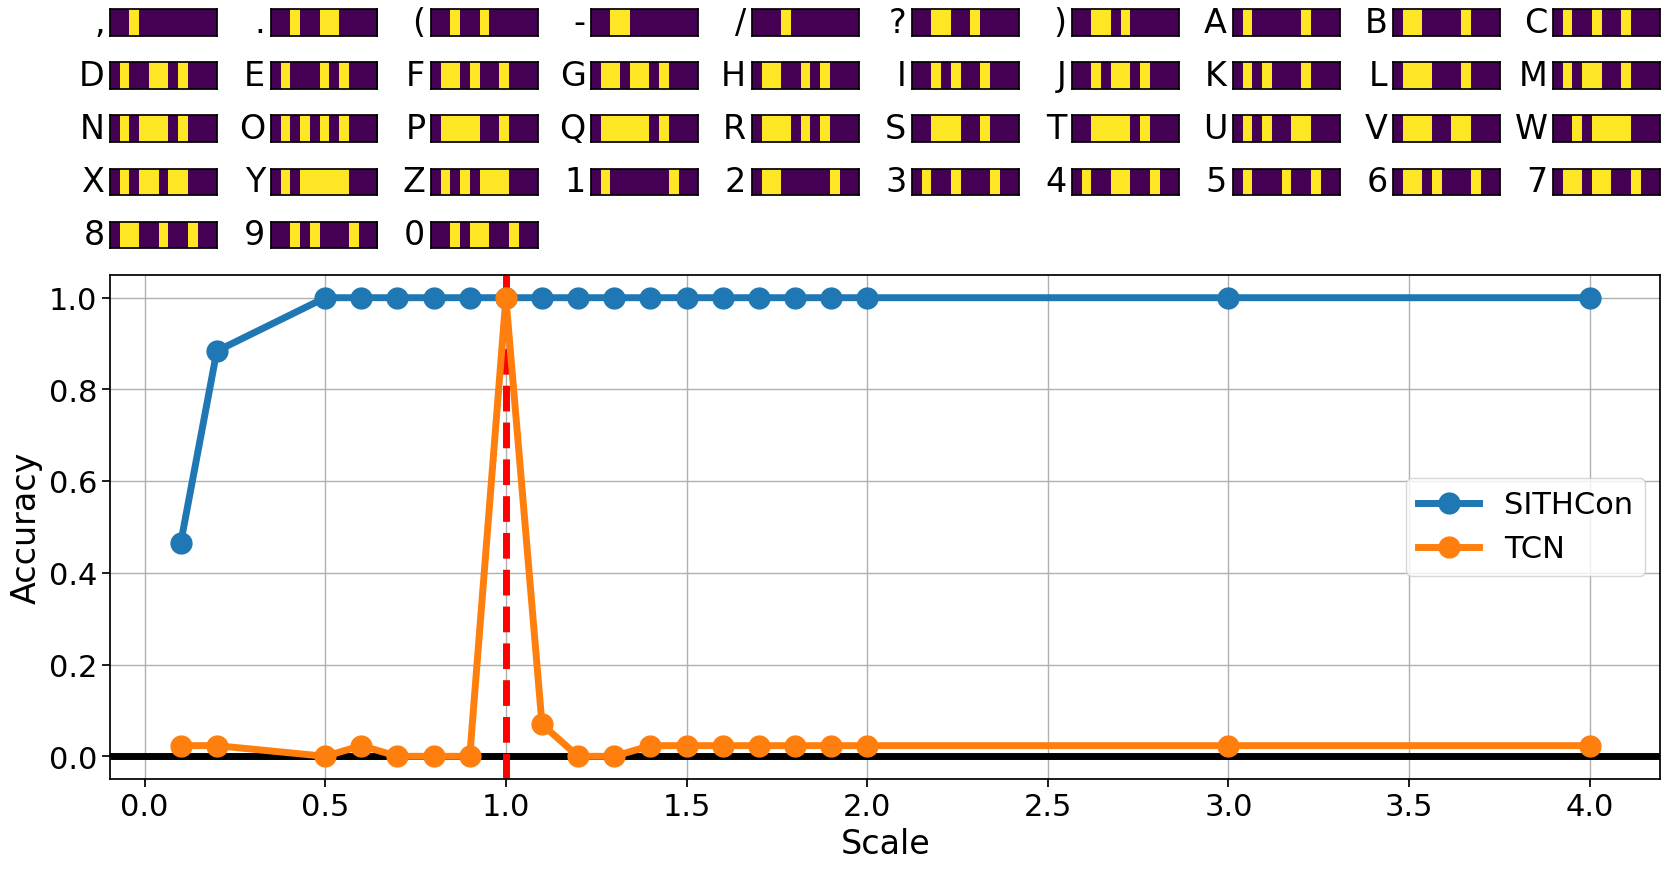

In [9]:
TCN_perfs = pd.read_pickle(join("perf", "tcn_braille_test.dill"))
SITH_perfs = pd.read_pickle(join("perf", "sithcon_braille_test.dill"))
print(SITH_perfs.head())

window_size = 20
lw=5
ms = 15
with sn.plotting_context("notebook", font_scale=2):
    fig = plt.figure(figsize=(20,10), )

    spec = gridspec.GridSpec(nrows=15, ncols=10, hspace=1, wspace=.5,
                             figure=fig)

    for x, k in enumerate(Braille_code_numpy.keys()):
        ax = fig.add_subplot(spec[int(x/10), x%10])
        ax.imshow(Braille_code_numpy[k][np.newaxis], aspect='auto')
        ax.set_ylabel(k, rotation=0, labelpad=4, ha='right', va='center')
        ax.set_xticks([])
        ax.set_yticks([])



    Trainscale = 10
    ax = fig.add_subplot(spec[5:, :])
    ax.axhline(0, color='black',
            linewidth=lw, ms=ms, label='_nolegend_')
    ax.axvline(Trainscale/Trainscale, color='red', linestyle='--',
            linewidth=lw, ms=ms, label='_nolegend_')
    ax.plot(SITH_perfs.scale/Trainscale, SITH_perfs.perf, marker='o',
            linewidth=lw, ms=ms)
    ax.plot(TCN_perfs.scale/Trainscale, TCN_perfs.perf, marker='o',
            linewidth=lw, ms=ms)


    ax.set_ylim(-.05, 1.05)
    ax.grid()
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Scale')
    ax.legend(['SITHCon', 'TCN'])
directory = "figs"
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(join('figs', 'Braille_decoder_Full.png'), dpi=100)
plt.savefig(join('figs', 'Braille_decoder_Full.pdf'), dpi=100)

In [11]:

id2key = subset
key2id = {}
for idx, s in enumerate(subset):
    key2id[s] = idx

X = [ttype(Braille_code_numpy[k])for k in subset]
Y = torch.LongTensor(np.arange(0,len(X)))


<ipython-input-11-f67fab118125>:6: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  X = [ttype(Braille_code_numpy[k])for k in subset]


In [12]:
nr = 10
iv = X[0]
iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0)
iv = iv.unsqueeze(-1)
iv1 = iv.repeat(1,1,1,1,nr)
iv2 = iv.repeat(1,1,1,1,nr*2)
iv_5 = iv.repeat(1,1,1,1,int(nr/2))
iv1 = iv1.reshape(-1)
iv2 = iv2.reshape(-1)
iv_5 = iv_5.reshape(-1)

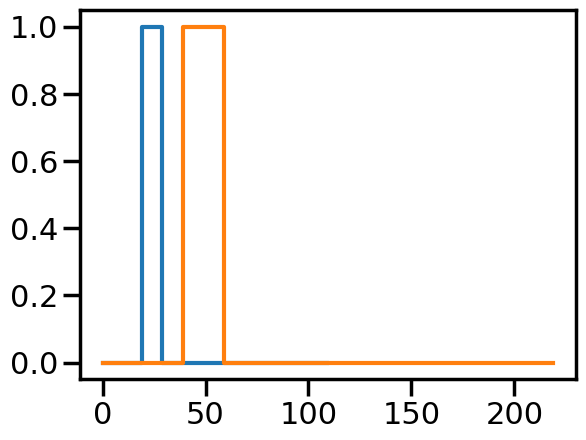

In [13]:
plt.step(range(iv1.shape[0]), iv1.cpu().numpy())
plt.step(range(iv2.shape[0]), iv2.cpu().numpy())


In [14]:
class SITHCon_Classifier(nn.Module):
    def __init__(self, out_classes, layer_params,
                 act_func=nn.ReLU, batch_norm=False,
                 dropout=.2):
        super(SITHCon_Classifier, self).__init__()
        last_channels = layer_params[-1]['channels']
        self.transform_linears = nn.ModuleList([nn.Linear(l['channels'], l['channels'])
                                                for l in layer_params])
        self.sithcon_layers = nn.ModuleList([SITHCon_Layer(l, act_func) for l in layer_params])
        self.to_out = nn.Linear(last_channels, out_classes)


    def forward(self, inp):

        x = inp
        #out = []
        for i in range(len(self.sithcon_layers)):
            x = self.sithcon_layers[i](x)

            x = F.relu(self.transform_linears[i](x[:,0,:,:].transpose(1,2)))
            x = x.unsqueeze(1).transpose(2,3)

            #out.append(x.clone())
        x = x.transpose(2,3)[:, 0, :, :]
        #x = x.transpose(2,3)[:, 0, :, :]
        x = self.to_out(x)
        return x

In [15]:
def gen_model(p):
    sp1 = dict(in_features=1,
               tau_min=.1, tau_max=3000, buff_max=6000,
               dt=1, ntau=p[0], k=p[1], g=0.0, ttype=ttype,
               channels=25, kernel_width=p[2], dilation=p[3],
               dropout=None, batch_norm=None)
    sp2 = dict(in_features=sp1['channels'],
               tau_min=.1, tau_max=3000, buff_max=6000,
               dt=1, ntau=p[0], k=p[1], g=0.0, ttype=ttype,
               channels=25, kernel_width=p[2], dilation=p[3],
               dropout=None, batch_norm=None)
    sp3 = dict(in_features=sp2['channels'],
               tau_min=.1, tau_max=3000, buff_max=6000,
               dt=1, ntau=p[0], k=p[1], g=0.0, ttype=ttype,
               channels=25, kernel_width=p[2], dilation=p[3],
               dropout=None, batch_norm=None)
    layer_params = [sp1, sp2, sp3]
    model = SITHCon_Classifier(len(X), layer_params, act_func=None,#nn.ReLU
                              ).cuda()
    return model

def test_model(model, X, Y):
    model.eval()
    evald = []
    evaldDict = {'test_perf':[],
                 'rate':[],
                 'tau_max':[],
                 'ntau':[],
                 'k':[],
                 'dilation':[],
                 'channels':[]}
    for nr in [1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]:
    #for nr in range(1,40,):
        perfs = []
        for batch_idx, iv in enumerate(X):
            iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
            iv = iv.unsqueeze(-1)
            iv = iv.repeat(1,1,1,1,nr)
            iv = iv.reshape(1,1,1,-1)
            tv = Y[batch_idx].to(device)
            out = model(iv)
            loss = loss_func(out[:, -1, :],
                             torch.cuda.LongTensor([tv]))


            perfs.append((torch.argmax(out[:, -1, :], dim=-1) ==
                          tv).sum().item()*1.0)
        evaldDict['test_perf'].append(sum(perfs)/len(perfs))
        evaldDict['rate'].append(nr)
        evaldDict['tau_max'].append(model.sithcon_layers[0].sithcon.sith.tau_max)
        evaldDict['ntau'].append(model.sithcon_layers[0].sithcon.sith.ntau)
        evaldDict['k'].append(model.sithcon_layers[0].sithcon.sith.k)
        evaldDict['dilation'].append(model.sithcon_layers[0].sithcon.dilation)
        evaldDict['channels'].append(model.sithcon_layers[0].sithcon.channels)

    return evaldDict

def save_outcome(outcome, filename):
    dat = pd.DataFrame(outcome)
    dat.to_csv(join('perf',filename))

In [16]:
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

# START

In [17]:

i = 0
p = [400, 35, 23, 2]
model = gen_model(p)


{'tau_min': 0.1, 'tau_max': 3000, 'buff_max': 6000, 'dt': 1, 'ntau': 400, 'k': 35, 'g': 0.0, 'ttype': <class 'torch.cuda.FloatTensor'>, 'dropout': None, 'batch_norm': None}


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


{'tau_min': 0.1, 'tau_max': 3000, 'buff_max': 6000, 'dt': 1, 'ntau': 400, 'k': 35, 'g': 0.0, 'ttype': <class 'torch.cuda.FloatTensor'>, 'dropout': None, 'batch_norm': None}
{'tau_min': 0.1, 'tau_max': 3000, 'buff_max': 6000, 'dt': 1, 'ntau': 400, 'k': 35, 'g': 0.0, 'ttype': <class 'torch.cuda.FloatTensor'>, 'dropout': None, 'batch_norm': None}


In [18]:
view_letter=15
inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
inp = inp.unsqueeze(-1)
inp = inp.repeat(1,1,1,1,Trainscale)
inp = inp.reshape(1,1,1,-1)
outN = model.sithcon_layers[0].tctct.sith(inp)
#outN = model.sithcon_layers[0].sithcon.sith(inp)
out = outN.transpose(3,1)
coutN = model.sithcon_layers[0].tctct.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))
#coutN = model.sithcon_layers[0].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))


inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
inp = inp.unsqueeze(-1)
inp = inp.repeat(1,1,1,1,Trainscale*2)
inp = inp.reshape(1,1,1,-1)
outS = model.sithcon_layers[0].tctct.sith(inp)
#outS = model.sithcon_layers[0].sithcon.sith(inp)
out = outS.transpose(3,1)
coutS = model.sithcon_layers[0].tctct.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))
#coutS = model.sithcon_layers[0].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))


inp = X[view_letter].unsqueeze(0).unsqueeze(0).unsqueeze(0)
inp = inp.unsqueeze(-1)
inp = inp.repeat(1,1,1,1,int(Trainscale/2))
inp = inp.reshape(1,1,1,-1)
outF = model.sithcon_layers[0].tctct.sith(inp)
#outF = model.sithcon_layers[0].sithcon.sith(inp)
out = outF.transpose(3,1)
coutF = model.sithcon_layers[0].tctct.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))
print(coutF.shape)
#coutF = model.sithcon_layers[0].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3])


torch.Size([55, 25, 1, 356])


In [19]:
scout1 = model.sithcon_layers[0].tctct.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))
#scout1 = model.sithcon_layers[0].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))
c=0
ax.plot(np.arange(0, scout1.shape[0]), scout1[:, c, 0, :].detach().cpu().T.max(0)[0])


<ipython-input-20-3360dd08132f>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""])
<ipython-input-20-3360dd08132f>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])
<ipython-input-20-3360dd08132f>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""])
<ipython-input-20-3360dd08132f>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])
<ipython-input-20-3360dd08132f>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""])
<ipython-input-20-3360dd08132f>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])


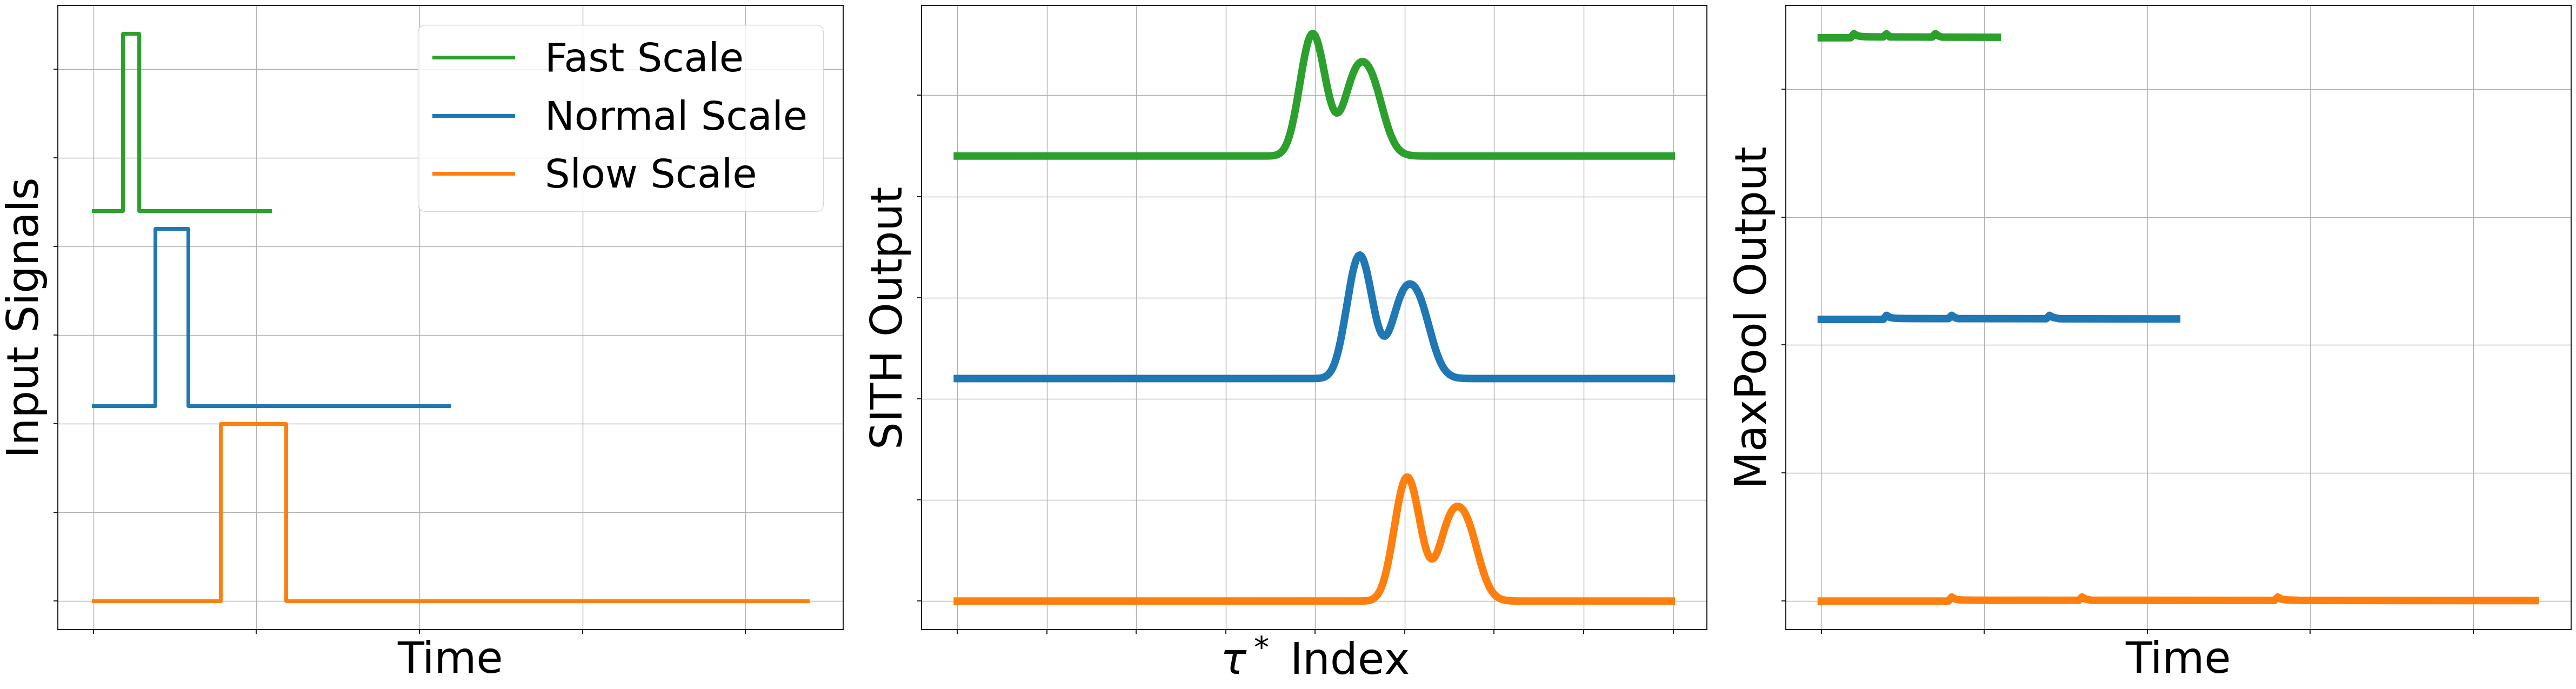

In [20]:
linew = 4
Trainscale=5
view_channel = 4
view_times = [-1, -1]
view_letter = 15
Testscale = 20
relu = nn.ReLU()
with sn.plotting_context("notebook", font_scale=4.8):
    fig = plt.figure(figsize=(60,15), )
    spec = gridspec.GridSpec(nrows=1, ncols=3, hspace=.1, wspace=.1,
                             figure=fig)
    ax = fig.add_subplot(spec[0])

    ax.step(range(iv_5.shape[0]),
            iv_5.cpu()+2.2,
            linewidth=5,
            color=pal[2])
    ax.step(range(iv1.shape[0]),
            iv1.cpu()+1.1,
            linewidth=5,
            color=pal[0])
    ax.step(range(iv2.shape[0]),
            iv2.cpu(),
            linewidth=5,
            color=pal[1])
    ax.legend(['Fast Scale', 'Normal Scale', 'Slow Scale'])
    ax.grid()
    ax.set_yticklabels([""])
    ax.set_xticklabels([""])
    ax.set_ylabel('Input Signals')
    ax.set_xlabel('Time')

    ax = fig.add_subplot(spec[1])
    ax.plot(outN[0, :, 0, -1].detach().cpu().numpy()+1.1,
       linewidth=10)
    ax.plot(outS[0, :, 0, -1].detach().cpu().numpy(),
       linewidth=10)
    ax.plot(outF[0, :, 0, -1].detach().cpu().numpy()+2.2,
       linewidth=10)
    ax.grid()
    ax.set_yticklabels([""])
    ax.set_xticklabels([""])
    ax.set_ylabel('SITH Output')
    ax.set_xlabel(r"$\tau^*$ Index")

    ax = fig.add_subplot(spec[2])
    c=0
    ax.plot(np.arange(0, coutN.shape[0]),
            coutN[:, c, 0, :].detach().cpu().T.max(0)[0]+1.1,
            linewidth=10);
    ax.plot(np.arange(0, coutS.shape[0]),
            coutS[:, c, 0, :].detach().cpu().T.max(0)[0],
            linewidth=10);
    ax.plot(np.arange(0, coutF.shape[0]),
            coutF[:, c, 0, :].detach().cpu().T.max(0)[0]+2.2,
            linewidth=10);
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_yticklabels([""])
    ax.set_xticklabels([""])
    ax.set_ylabel('MaxPool Output')
plt.savefig(join('figs', '3scale_whySITHworks.png'), dpi=150,  transparent=True)
plt.savefig(join('figs', '3scale_whySITHworks.pdf'), dpi=150,  transparent=True)
plt.savefig(join('figs', '3scale_whySITHworks.svg'), dpi=150,  transparent=True)

<ipython-input-21-a44f3c58ca71>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""])
<ipython-input-21-a44f3c58ca71>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])
<ipython-input-21-a44f3c58ca71>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""])
<ipython-input-21-a44f3c58ca71>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])
<ipython-input-21-a44f3c58ca71>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""])
<ipython-input-21-a44f3c58ca71>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])


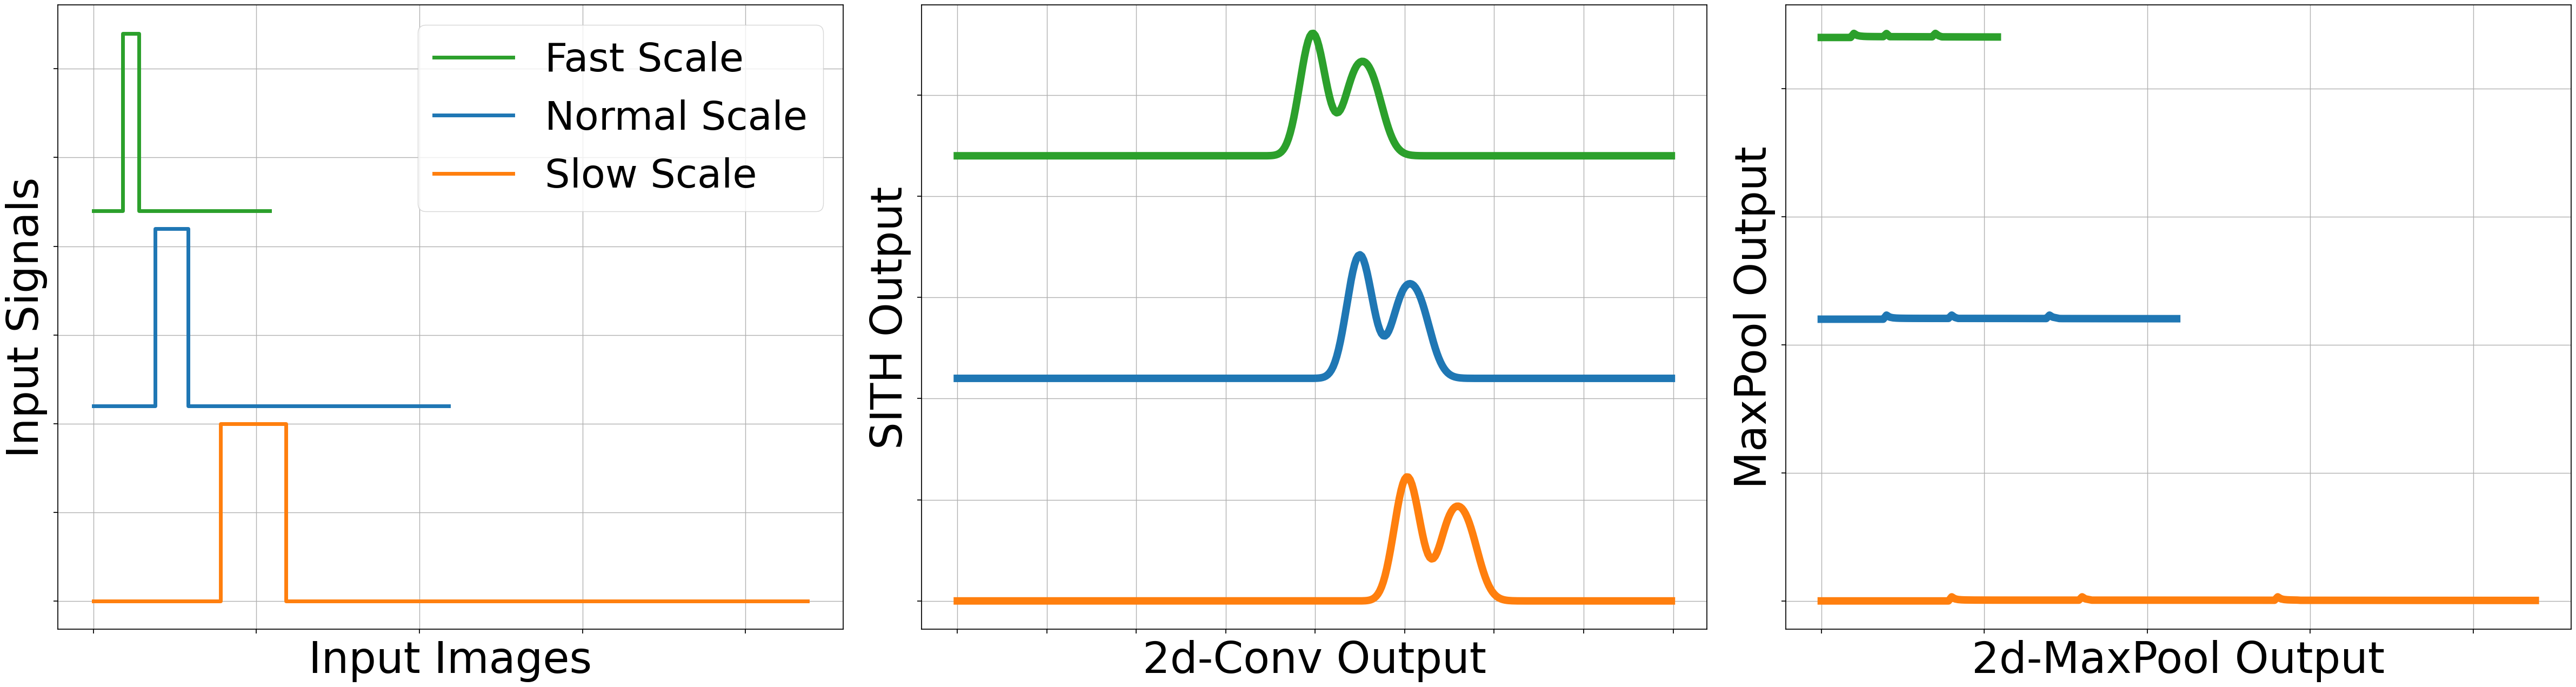

In [21]:
linew = 4
Trainscale=5
view_channel = 4
view_times = [-1, -1]
view_letter = 15
Testscale = 20
relu = nn.ReLU()
with sn.plotting_context("notebook", font_scale=4.8):
    fig = plt.figure(figsize=(60,15), )
    spec = gridspec.GridSpec(nrows=1, ncols=3, hspace=.1, wspace=.1,
                             figure=fig)
    ax = fig.add_subplot(spec[0])

    ax.step(range(iv_5.shape[0]),
            iv_5.cpu()+2.2,
            linewidth=5,
            color=pal[2])
    ax.step(range(iv1.shape[0]),
            iv1.cpu()+1.1,
            linewidth=5,
            color=pal[0])
    ax.step(range(iv2.shape[0]),
            iv2.cpu(),
            linewidth=5,
            color=pal[1])
    ax.legend(['Fast Scale', 'Normal Scale', 'Slow Scale'])
    ax.grid()
    ax.set_yticklabels([""])
    ax.set_xticklabels([""])
    ax.set_ylabel('Input Signals')
    ax.set_xlabel('Input Images')

    ax = fig.add_subplot(spec[1])
    ax.plot(outN[0, :, 0, -1].detach().cpu().numpy()+1.1,
       linewidth=10)
    ax.plot(outS[0, :, 0, -1].detach().cpu().numpy(),
       linewidth=10)
    ax.plot(outF[0, :, 0, -1].detach().cpu().numpy()+2.2,
       linewidth=10)
    ax.grid()
    ax.set_yticklabels([""])
    ax.set_xticklabels([""])
    ax.set_ylabel('SITH Output')
    ax.set_xlabel("2d-Conv Output")

    ax = fig.add_subplot(spec[2])
    c=0
    ax.plot(np.arange(0, coutN.shape[0]),
            coutN[:, c, 0, :].detach().cpu().T.max(0)[0]+1.1,
            linewidth=10);
    ax.plot(np.arange(0, coutS.shape[0]),
            coutS[:, c, 0, :].detach().cpu().T.max(0)[0],
            linewidth=10);
    ax.plot(np.arange(0, coutF.shape[0]),
            coutF[:, c, 0, :].detach().cpu().T.max(0)[0]+2.2,
            linewidth=10);
    ax.grid()
    ax.set_xlabel('2d-MaxPool Output')
    ax.set_yticklabels([""])
    ax.set_xticklabels([""])
    ax.set_ylabel('MaxPool Output')

plt.savefig(join('figs', 'words_i_need.svg'), dpi=150,  transparent=True)

In [ ]:
inp = X[view_letter].unsqueeze(0).unsqueeze(0)
inp = inp.unsqueeze(-1)
inp = inp.repeat(1,1,1,Trainscale)
inp = inp.reshape(1,1,-1)
coutN = conv_layer(inp)
print(outN.shape)
#coutN = model.sithcon_layers[0].sithcon.conv(out.reshape(-1, 1, out.shape[2], out.shape[3]))


inp = X[view_letter].unsqueeze(0).unsqueeze(0)
inp = inp.unsqueeze(-1)
inp = inp.repeat(1,1,1,Trainscale*2)
inp = inp.reshape(1,1,-1)
coutS = conv_layer(inp)
print(outN.shape)

inp = X[view_letter].unsqueeze(0).unsqueeze(0)
inp = inp.unsqueeze(-1)
inp = inp.repeat(1,1,1,int(Trainscale/2))
inp = inp.reshape(1,1,-1)
coutF = conv_layer(inp)


NameError: ignored

<ipython-input-22-10211ae86fc9>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""])
<ipython-input-22-10211ae86fc9>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])
<ipython-input-22-10211ae86fc9>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""])
<ipython-input-22-10211ae86fc9>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])


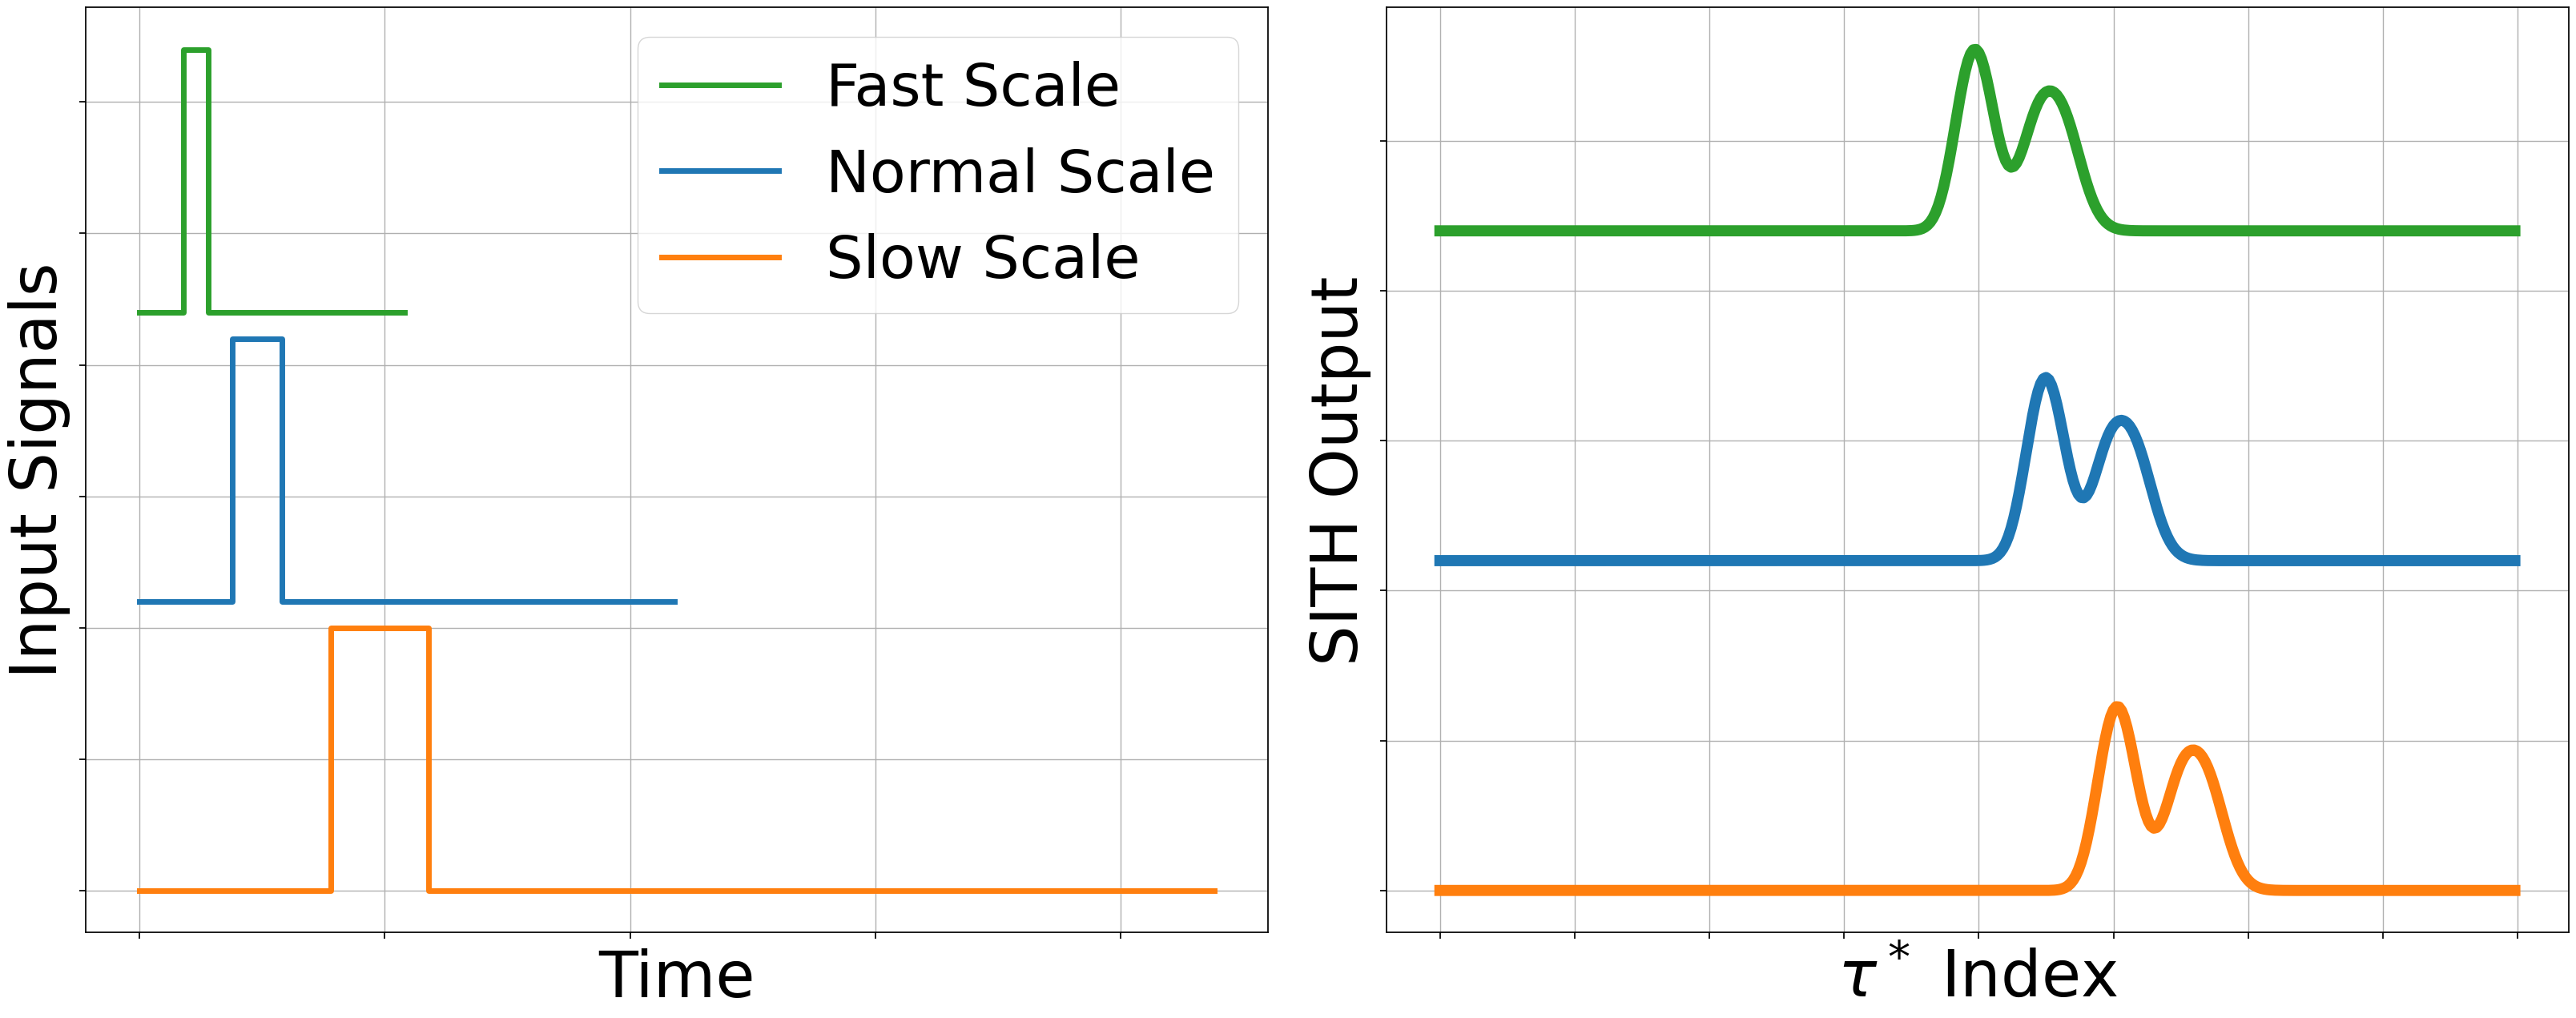

In [22]:
linew = 4
Trainscale=5
view_channel = 4
view_times = [-1, -1]
view_letter = 15
Testscale = 20
relu = nn.ReLU()
with sn.plotting_context("notebook", font_scale=4.8):
    fig = plt.figure(figsize=(40,15), )
    spec = gridspec.GridSpec(nrows=1, ncols=2, hspace=.1, wspace=.1,
                             figure=fig)
    ax = fig.add_subplot(spec[0])

    ax.step(range(iv_5.shape[0]),
            iv_5.cpu()+2.2,
            linewidth=5,
            color=pal[2])
    ax.step(range(iv1.shape[0]),
            iv1.cpu()+1.1,
            linewidth=5,
            color=pal[0])
    ax.step(range(iv2.shape[0]),
            iv2.cpu(),
            linewidth=5,
            color=pal[1])
    ax.legend(['Fast Scale', 'Normal Scale', 'Slow Scale'])
    ax.grid()
    ax.set_yticklabels([""])
    ax.set_xticklabels([""])
    ax.set_ylabel('Input Signals')
    ax.set_xlabel('Time')

    ax = fig.add_subplot(spec[1])
    ax.plot(outN[0, :, 0, -1].detach().cpu().numpy()+1.1,
       linewidth=10)
    ax.plot(outS[0, :, 0, -1].detach().cpu().numpy(),
       linewidth=10)
    ax.plot(outF[0, :, 0, -1].detach().cpu().numpy()+2.2,
       linewidth=10)
    ax.grid()
    ax.set_yticklabels([""])
    ax.set_xticklabels([""])
    ax.set_ylabel('SITH Output')
    ax.set_xlabel(r"$\tau^*$ Index")

plt.savefig(join('figs', '3scale_whySITHworks.png'), dpi=150)
plt.savefig(join('figs', '3scale_whySITHworks.pdf'), dpi=150)